<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Principal Component Analysis
              
</p>
</div>

Data Science Cohort Live NYC 2023

<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [4]:
from scipy.special import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

%matplotlib inline

# Learning Goals

- Explain the concepts behind principal component analysis (PCA)
- Explain how PCA addresses the problem of multicollinearity
- Explain the idea of eigendecomposition
- Implement PCA using `sklearn`

#### Motivation: The curse of dimensionality

In [5]:

%%capture cod

def sphere_calc(m, R):
    numerator = (R**m * np.pi**(m/2))
    denom = gamma(m/2 + 1)
    
    return numerator/denom

dim_list = pd.Series(np.arange(1,21))
sph_vol_list = dim_list.map(lambda M: sphere_calc(M, 2)) # get +- 2 std of standardized variables

density_vs_dim = 5000/sph_vol_list
fig, ax = plt.subplots()
sns.lineplot(x = density_vs_dim.index, y = density_vs_dim.values, ax = ax)
ax.set_ylabel('Point density')
ax.set_xlabel('Number of Features')
ax.set_title('Point density:  feature dimension scaling')
plt.show()


- Need good statistical sampling in feature space for training
- Dataset becomes sparse in high dimension. Hard to do statistical learning.


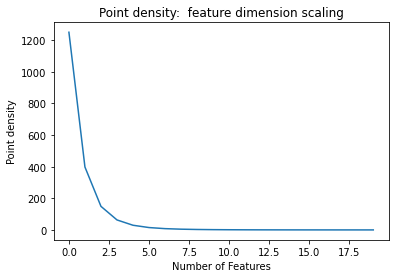

In [6]:
cod()

Small numbers (low density):

- large sample-to-sample fluctuations.

High variance from dimensionality: hard to train model that generalizes.


Another issue in data with a ton of features:
- many of the features are likely correlated with each other
- high variance


## How could we address this problem?


Could keep all variables and regularize.
   

Or could figure out how to reduce dimension:

- construct smaller set of variables that are combinations of original variables
- largely account for variation scale and correlations of features with this smaller set
- i.e., reduce dim, preserve as much information as possible

#### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a tool for reducing the dimensionality of our data in a way that tries to preserve information. It does this by projecting our data from a higher-dimensional space onto a lower-dimensional space. The PCA algorithm chooses a lower-dimensional space to project to that will preserve as much variance as possible from our original dataset.

<img src = "Images/PCA_basics.gif" width = 800 />

- Rotate to new coordinate system: 
    - directions characteristic of data spread in various dimensions.
    - new features uncorrelated (perpendicular)
- Find direction(s) of maximum variance:
    - project data onto this lower-D space.

Often doing this in much higher-D spaces.
- Very surprising how low the dimensionality capturing most of the feature variance can be.

Let's try an implement within given situation:

- Predict the cost to ship a package based on its features. 

In [7]:
packages = pd.read_csv('data/packages.csv')
packages.head(3)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722


In [8]:
packages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Shipping Cost ($)  30 non-null     int64
 1   Length (in)        30 non-null     int64
 2   Width (in)         30 non-null     int64
 3   Height (in)        30 non-null     int64
 4   Weight (lb)        30 non-null     int64
 5   Distance (mi)      30 non-null     int64
dtypes: int64(6)
memory usage: 1.5 KB


- Quite a few features for a small dataset,
- Also: likely that physical dimensions are correlated

Check out those correlations:

PCA does not use this **correlation matrix**, which is conveniently scaled between -1 and 1. Rather, it uses the **covariance matrix**, which is scaled in square units of the original variables. This makes PCA very sensitive to the scale of the variables.

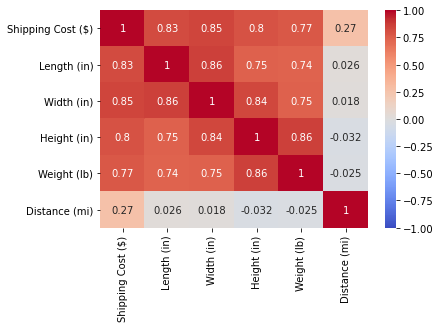

In [9]:
packages_scaled = (packages - packages.mean())/packages.std()

sns.heatmap(packages_scaled.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm');

Very high correlations between the different physical package characteristics.

- Some combination of variables as one variable
- Another set for the other

- One as strong mixture of physical features
- other dominated by Distance.
    

## Dimensionality
You can think about each variable as a dimension, and thus each package as a data point. If we take just one feature, we can easily visualize this in 2 dimensional space

Visualizing: looks like a linear regression might work.
- But don't drop all features except length
- More principled way.

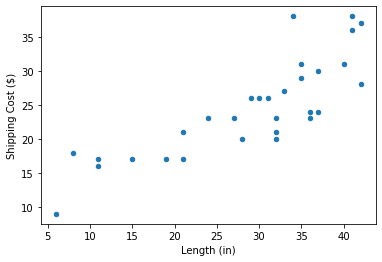

In [10]:
packages.plot(kind='scatter', y='Shipping Cost ($)', x='Length (in)');

You can think of each package as a point in six-dimensional space - 5 dimensions for our features and 1 for our target.

In [11]:
X = packages.drop(columns = ['Shipping Cost ($)'])
y = packages['Shipping Cost ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Now standardize our features:
- Failing to do so makes finding directions of variance:
    - dependent on scale of individual features
- Want to understand directions of high data variance unbiased /by the scale of individual features.

In [12]:
scaler = StandardScaler()
X_tr_norm = scaler.fit_transform(X_train)
X_tt_norm = scaler.transform(X_test)

PCA: 
- relies on decomposing this **covariance matrix** $X^TX$ of scaled/centered data:

In [13]:
N_tr = X_tr_norm.shape[0]
Xcov = (X_tr_norm.T@X_tr_norm)/N_tr 
Xcov

array([[1.        , 0.86987689, 0.70175645, 0.68391043, 0.0747599 ],
       [0.86987689, 1.        , 0.82233066, 0.72468779, 0.10000156],
       [0.70175645, 0.82233066, 1.        , 0.86691334, 0.08969905],
       [0.68391043, 0.72468779, 0.86691334, 1.        , 0.02508831],
       [0.0747599 , 0.10000156, 0.08969905, 0.02508831, 1.        ]])

This really nothing more than the Pearson correlation matrix

In [14]:
X_train.corr()

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
Length (in),1.000000,0.869877,0.701756,0.683910,0.074760
Width (in),0.869877,1.000000,0.822331,0.724688,0.100002
Height (in),0.701756,0.822331,1.000000,0.866913,0.089699
Weight (lb),0.683910,0.724688,0.866913,1.000000,0.025088
Distance (mi),0.074760,0.100002,0.089699,0.025088,1.000000


So first step of PCA

Transform coordinates: constructs new features

Linear combination of old features:

$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = S \begin{bmatrix} X_1 \\ X_2 \end{bmatrix} = \begin{bmatrix} s_{11} & s_{12} \\ s_{21} & s_{22} \end{bmatrix}\begin{bmatrix} X_1 \\ X_2 \end{bmatrix}   $$


$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = X_1 \begin{bmatrix} s_{11} \\ s_{12} \end{bmatrix} + X_2 \begin{bmatrix} s_{21} \\ s_{22} \end{bmatrix}   $$


$$ \begin{bmatrix} PC_1 \\ PC_2 \end{bmatrix} = X_1 \textbf{s}_1 + X_2\textbf{s}_2  $$

where $\textbf{s}_1$ and $\textbf{s}_2$ forms new coordinate system.

<img src = "Images/PCA_closeup.png" />

In rotated frame:
    
- New features not correlated.

<img src = "Images/pca_rot.jpg" width = 350 />

Getting variance matrix in new coordinate system:
- Get variance along specific PC1, PC2

Task is two fold:
- find transformation that yields the principal axes of variation in data
- get variance of data in these principal directions 

**Numpy:**

Finds characteristic (eigen) directions of variance and gets (eigen) values of the variance along characteristic directions

In [17]:
from numpy import linalg
eig, eigvecs = linalg.eig(Xcov)


## Eigendecomposition

We will use an **eigendecomposition** of the covariance matrix to create a new set of dimensions. We can then decide how many of these dimensions to keep based on how much variance is captured by each dimension.

Here, we show you how to do this using the NumPy `.eig()` function, but we will learn how to do PCA more easily in `sklearn` later.

## Eigenvalues

**Eigenvalues** represent the relative amount of variance captured by each new dimension. The average eigenvalue will be 1, so we look for values over 1 to identify dimensions that capture more variance than average.

In [16]:
eig

array([3.34534235, 0.41555877, 0.07660028, 0.16736752, 0.99513107])

Covariance matrix in new coordinate system

In [23]:
colname = ['PC' + str(n) for n in range(len(Xcov))]
Xcov_PCA = pd.DataFrame(np.diag(eig), index = colname, columns = colname)
Xcov_PCA

,PC0,PC1,PC2,PC3,PC4
PC0,3.345342,0.000000,0.0000,0.000000,0.000000
PC1,0.000000,0.415559,0.0000,0.000000,0.000000
PC2,0.000000,0.000000,0.0766,0.000000,0.000000
PC3,0.000000,0.000000,0.0000,0.167368,0.000000
PC4,0.000000,0.000000,0.0000,0.000000,0.995131


### Proportion of Variance


You can also divide your eigenvalues by the number of features and then interpret them as the _proportion of variance in the features_ captured by each dimension.

In [18]:
eig/5

array([0.66906847, 0.08311175, 0.01532006, 0.0334735 , 0.19902621])

Covariance matrix in new, rotated coordinate system

It looks like we have one great dimension capturing 3.4x more variance than average, one OK dimension capturing an average amount of variance, and three other dimensions that don't capture much variance. This is in line with what we were expecting! It means that we can just use the first two dimensions - and drop the last three - without losing much variance/information from our predictors.

## Eigenvectors (aka Principal Components)

**Eigenvectors** represent the new dimensions, which we call **principal components** when doing PCA. There is one eigenvector for each dimension, and they are all combined together into one matrix.

In [24]:
eigvecs

array([[ 0.48652229,  0.61914018,  0.40602105, -0.46351601, -0.01616536],
       [ 0.51226395,  0.36094472, -0.60909298,  0.48608555,  0.00557959],
       [ 0.50818102, -0.41001924,  0.57619555,  0.49114956, -0.02017601],
       [ 0.4886595 , -0.56157003, -0.36329337, -0.55211671, -0.09505821],
       [ 0.06201335, -0.05392282, -0.0130102 , -0.05303766,  0.9951203 ]])

The components of the principal directions in terms of original features:

In [25]:
pc_comp = pd.DataFrame(eigvecs.T,
                       index = colname,
                       columns = X_train.columns)
pc_comp

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.486522,0.512264,0.508181,0.488659,0.062013
PC1,0.619140,0.360945,-0.410019,-0.561570,-0.053923
PC2,0.406021,-0.609093,0.576196,-0.363293,-0.013010
PC3,-0.463516,0.486086,0.491150,-0.552117,-0.053038
PC4,-0.016165,0.005580,-0.020176,-0.095058,0.995120


In PCA, the values in our eigenvectors are called **component weights**, and they tell us how much variance of each feature is captured by that dimension. These weights range from -1 to 1, but the relative sizes are what matter.

PCs are mixtures of original features:
- In our case very equally distributed across different features.
- PCs are usually NOT interpretable

Looking at the variance and principal components side-by-side

In [26]:
Xcov_PCA

,PC0,PC1,PC2,PC3,PC4
PC0,3.345342,0.000000,0.0000,0.000000,0.000000
PC1,0.000000,0.415559,0.0000,0.000000,0.000000
PC2,0.000000,0.000000,0.0766,0.000000,0.000000
PC3,0.000000,0.000000,0.0000,0.167368,0.000000
PC4,0.000000,0.000000,0.0000,0.000000,0.995131


In [27]:
pc_comp

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.486522,0.512264,0.508181,0.488659,0.062013
PC1,0.619140,0.360945,-0.410019,-0.561570,-0.053923
PC2,0.406021,-0.609093,0.576196,-0.363293,-0.013010
PC3,-0.463516,0.486086,0.491150,-0.552117,-0.053038
PC4,-0.016165,0.005580,-0.020176,-0.095058,0.995120


No question that PC0 and PC1 dominate variance:

- Most dominant always called **first principal component**
- Second most dominant: **second principal component**, etc.

- First principal component has high weight across all features.
- Second weights distance (not physical package attribute)

Together enough to capture most variance.

#### Orthogonality: formal way of saying something we know

The directions we found are **orthogonal** or perpendicular to each other:
- Same as saying: PCs are not correlated with each other.
- In such a case: dot products between different PC vectors vanish.

$$ \textbf{u}\cdot \textbf{v} = \textbf{u}^T\textbf{v} = \begin{bmatrix} u_1 & u_2 \end{bmatrix}\begin{bmatrix} v_1 \\ v_2 \end{bmatrix}  = 0 $$

$$ \begin{bmatrix} 1 & -1 \end{bmatrix}\begin{bmatrix} 1 \\ 1 \end{bmatrix}  = 0 $$


<img src = "Images/pca_rot.jpg" width = 350 />

What we did:

<center><img src = "Images/PCA_orth.png" width = 450 /></center>

In [28]:
PC1 = eigvecs[:, 0]
PC2 = eigvecs[:, 1]
PC1.dot(PC2)

0.0

#### The final step: transforming the data

We will now use these principal components to create new features. 
- These features will be weighted sums (aka **linear combinations**) of existing features
- Using the component weights from the eigenvectors.

Take first three PCs only: these **dominate** variance:
- Capture most of feature space.
- Decorrelated variables. Variance not an issue.

We will now create feature using the first 3 PCS: 

In [29]:
firstthree = pc_comp.iloc[0:3]
firstthree

,Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
PC0,0.486522,0.512264,0.508181,0.488659,0.062013
PC1,0.619140,0.360945,-0.410019,-0.561570,-0.053923
PC2,0.406021,-0.609093,0.576196,-0.363293,-0.013010


<img src = "Images/PCA_basics.gif" width = 500 />

Projecting the data onto these principal components

In [30]:
projected = X_tr_norm@firstthree.T

projected.head()

,PC0,PC1,PC2
0,-3.624643,-0.418853,-0.192736
1,-2.420933,-0.979696,-0.028583
2,1.488597,-0.111207,0.004552
3,-0.396730,0.693352,0.324290
4,0.603426,0.274987,-0.306055


- We have lessened collinearity issue.
- Also reduced dimensionality considerably.

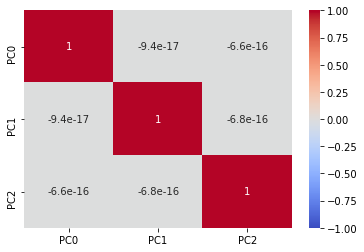

In [31]:
sns.heatmap(projected.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap= 'coolwarm');

#### Modeling

Now let's compare linear regression models with...

* All five original features 
* Only 2 best new features

**Model 1: All base features**:

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
sm1 = LinearRegression()
sm1.fit(X_tr_norm, y_train)
sm1.score(X_tr_norm, y_train)

0.8487563271406994

In [34]:
from sklearn.metrics import r2_score

In [35]:
y_test_hat = sm1.predict(X_tt_norm)
r2_score(y_test, y_test_hat)

0.8381998668831205

**Model 2: Major principal components**:

In [36]:
sm3 = LinearRegression()
sm3.fit(projected, y_train) # takes in PCA-ed + projected features

LinearRegression()

PCA transform scaled test data:
- Feed in to make prediction

In [37]:
projected_test = X_tt_norm@firstthree.T

In [38]:
#transformed train set
y_train_pred = sm3.predict(projected) 

In [39]:
 # transformed test set 
y_pred = sm3.predict(projected_test) 

In [40]:
r2_score(y_train_pred, y_train)


0.7057930322124408

In [41]:
r2_score(y_test, y_pred)

0.8502864078395633

## PCA in `sklearn`

As always, `sklearn` makes this all much easier, this time with the `PCA()` class.

In [ ]:
pca = PCA(n_components=3) # Check out how `n_components` works

# fits PCA (stores eigenvalues/eigenvectors)
# applies PCA transformation/projection on scaled training data
X_tr_pca = pca.fit_transform(X_tr_norm) 

X_tr_pca[:5,:]

Saved parameters:
- **Get eigenvectors determined from covariance matrix of training data**
- Get eigenvalues: variance of data in different principal directions

In [ ]:
pca.components_

- These are components of PC vectors in original feature space.
- Sometimes the signs get flipped on the eigenvectors - don't worry about it. Think of "up" and "down" as both representing the same dimension, just in opposite directions.

Saved parameters:
- Get eigenvectors determine from covariance matrix of training data
- **Get eigenvalues of covariance matrix of training data:**
   - **variance of data in different principal directions**

In [ ]:
pca.explained_variance_

Often useful to see percentage of total variance explained by each PC:
- percentage of eigenvalue (i.e., variance) of given PC
- with respect to total variance of the data 

In [ ]:
pca.explained_variance_ratio_

After PCA, you can use your transformed data as you would in any model:
- PCA acts as a transformer in the pipeline 

In [ ]:
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), ('pca', PCA(n_components = 3)), ('model', LinearRegression())  ]
mod_pipe = Pipeline(steps)

Fitting the model on unscaled data:
- fits/transforms scaler
- PCA and transform scalef train set
- PCA-ed features sent to model 

In [ ]:
mod_pipe.fit(X_train,y_train) 

Now evaluate:
- train set performance
- test set generalization

In [ ]:
mod_pipe.score(X_train,y_train) 

In [ ]:
#test_pred = mod_pipe.predict(X_test)
#r2_score(y_test,test_pred)
# or
mod_pipe.score(X_test,y_test) 


May need to tune n_components using grid-searching:
- but EDA can usually help a lot with this
- get eigenvalues of scaled/centered variance matrix and determine how many principal components are significant.

# Scenario: Car Properties

Use PCA to reduce the dimensionality of features in the example below: Predict car mpg using car properties. We've done the data prep. Now you practice the modeling, including scoring on the test set.

## Data Prep

In [ ]:
cars = pd.read_csv('data/cars.csv')

In [ ]:
cars.head()

In [ ]:
cars.dtypes

In [ ]:
cars[' cubicinches'].replace(' ', np.nan, inplace=True)
cars[' cubicinches'] = cars[' cubicinches'].astype(float)

In [ ]:
cars[' weightlbs'].replace(' ', np.nan, inplace=True)
cars[' weightlbs'] = cars[' weightlbs'].astype(float)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('mpg', axis=1),
                                                    cars['mpg'],
                                                   random_state=20)

In [ ]:
ct1 = ColumnTransformer(transformers=[
    ('imputer', SimpleImputer(), [1, 3])],
    remainder='passthrough')

In [ ]:
ct2 = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [0, 1, 2, 3, 4, 5]),
    ('ohe', OneHotEncoder(), [6])],
    remainder='passthrough')

In [ ]:
pipe = Pipeline(steps=[
    ('ct1', ct1),
    ('ct2', ct2)
])

In [ ]:
pipe

In [ ]:
pipe.fit(X_train)

In [ ]:
X_tr_pp = pipe.transform(X_train)
X_te_pp = pipe.transform(X_test)

## First Model w/o PCA


In [ ]:
## Let's start with a linear regression

lr = LinearRegression().fit(X_tr_pp, y_train)

## Score on train

lr.score(X_tr_pp, y_train)

In [ ]:
## Score on test

lr.score(X_te_pp, y_test)

In [ ]:
# Get the coefficients of the best-fit hyperplane

lr.coef_

Thus, our best-fit hyperplane is given by:

$2.177\times in^3\_sd - 4.645\times lbs.\_sd - 1.555\times cyl\_sd - 1.154\times hp\_sd -  0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

## Model w PCA


In [ ]:
cars_pca = PCA(n_components=3) 

X_train_new = cars_pca.fit_transform(X_tr_pp)
X_test_new = cars_pca.transform(X_te_pp)

In [ ]:
cars_pca.components_

The results of our PCA are as follows:

**PC1** = 0.465 * cubicinches_sd + 0.435 * weightlbs_sd + 0.449 * cylinders_sd + 0.454 * hp_sd - 0.349 * time-to-60_sd - 0.187 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.140 * US

**PC2** = -0.099 * cubicinches_sd - 0.196 * weightlbs_sd - 0.131 * cylinders_sd + 0.006 * hp_sd - 0.125 * time-to-60_sd - 0.937 * year_sd + 0.129 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.141 * cubicinches_sd + 0.342 * weightlbs_sd + 0.187 * cylinders_sd - 0.144 * hp_sd + 0.851 * time-to-60_sd - 0.239 * year_sd + 0.043 * Europe - 0.132 * Japan + 0.089 * US

### Modeling with New Dimensions

Now that we have optimized our features, we can build a new model with them!

In [ ]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_new, y_train)
lr_pca.score(X_train_new, y_train)

In [ ]:
X_test_new = cars_pca.transform(X_te_pp)

In [ ]:
lr_pca.score(X_test_new, y_test)

In [ ]:
lr_pca.coef_

Thus, our best-fit hyperplane is given by:

$-2.967\times PC1 - 1.162\times PC2 -2.486\times PC3$

Of course, since the principal components are just linear combinations of our original predictors, we could re-express this hyperplane in terms of those original predictors!

And if the PCA was worth anything, we should expect the new linear model to be *different from* the first!

Recall that we had:

**PC1** = 0.465 * cubicinches_sd + 0.435 * weightlbs_sd + 0.449 * cylinders_sd + 0.454 * hp_sd - 0.349 * time-to-60_sd - 0.187 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.140 * US

**PC2** = -0.099 * cubicinches_sd - 0.196 * weightlbs_sd - 0.131 * cylinders_sd + 0.006 * hp_sd - 0.125 * time-to-60_sd - 0.937 * year_sd + 0.129 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.141 * cubicinches_sd + 0.342 * weightlbs_sd + 0.187 * cylinders_sd - 0.144 * hp_sd + 0.851 * time-to-60_sd - 0.239 * year_sd + 0.043 * Europe - 0.132 * Japan + 0.089 * US

Therefore, our new PCA-made hyperplane can be expressed as:

$-2.967\times(0.465\times in^3\_sd + 0.435\times lbs.\_sd + 0.449\times cyl\_sd + 0.454\times hp\_sd - 0.349\times time_{60}\_sd - 0.187\times yr\_sd - 0.068\times brand_{Europe} - 0.073\times brand_{Japan} + 0.140\times brand_{US})$ <br/> $- 1.162\times(-0.099\times in^3\_sd - 0.196\times lbs.\_sd - 0.131\times cyl\_sd + 0.006\times hp\_sd - 0.125\times time_{60}\_sd - 0.937\times yr\_sd + 0.129\times brand_{Europe} + 0.022\times brand_{Japan} - 0.152\times brand_{US})$ <br/> $- 2.486\times(0.141\times in^3\_sd + 0.342\times lbs.\_sd + 0.187\times cyl\_sd -0.144\times hp\_sd + 0.851\times time_{60}\_sd - 0.239\times yr\_sd + 0.043\times brand_{Europe} - 0.132\times brand_{Japan} + 0.089\times brand_{US})$

Let's make these calculations:

In [ ]:
print(f'cubicinches_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 0], 3)}')
print(f'weightlbs_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 1], 3)}')
print(f'cylinders_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 2], 3)}')
print(f'horsepower_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 3], 3)}')
print(f'timeto60_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 4], 3)}')
print(f'year_sd coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 5], 3)}')
print(f'Europe coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 6], 3)}')
print(f'Japan coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 7], 3)}')
print(f'US coef: {round(lr_pca.coef_ @ cars_pca.components_[:, 8], 3)}')

So our best-fit hyperplane using PCA is:

$-1.616\times in^3\_sd - 1.913\times lbs.\_sd - 1.646\times cyl\_sd - 0.996\times hp\_sd - 0.933\times time_{60}\_sd + 2.237\times yr\_sd - 0.055\times brand_{Europe} + 0.517\times brand_{Japan} - 0.462\times brand_{US}$

Recall that our first linear regression model had:

$2.177\times in^3\_sd - 4.645\times lbs.\_sd - 1.555\times cyl\_sd - 1.154\times hp\_sd -  0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

which is clearly a different hyperplane.

## Visualizations

In [ ]:
# Reassembling the whole dataset for the sake of visualization
X_transformed = np.vstack([X_train_new, X_test_new])
y_new = np.concatenate([y_train, y_test])

In [ ]:
f, a = plt.subplots()
a.plot(X_transformed[:, 0], y_new, 'r.');

In [ ]:
f, a = plt.subplots()
a.plot(X_transformed[:, 1], y_new, 'g.');

In [ ]:
f, a = plt.subplots()
a.plot(X_transformed[:, 2], y_new, 'k.');

In [ ]:
df = pd.DataFrame(np.hstack([X_transformed, y_new[:, np.newaxis]]),
                  columns=['PC1', 'PC2', 'PC3', 'y'])
df.head()

## Level Up: Relation to Linear Regression

Question: Is the first principal component the same line we would get if we constructed an ordinary least-squares regression line?

Answer: No. The best-fit line minimizes the sum of squared errors, i.e. the minimum sum of ("vertical") distances between the predictions and the real values of the dependent variable. Principal Component Analysis, by contrast, is not a modeling procedure and so has no target. The first principal component thus cannot minimize the sum of distances between predictions and real values; instead, it minimizes the sum of ("perpendicular") distances between the data points and *it (the line) itself*.

Suppose we look at MPG vs. z-scores of weight in lbs. Let's make a scatter plot:

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight');

Let's add the best-fit line:

In [ ]:
beta1 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).coef_
beta0 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).intercept_

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Now let's see what the principal component looks like. We'll make use of the `inverse_transform()` method of `PCA()` objects.

In [ ]:
pc1 = PCA(n_components=1).fit(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc = pc1.transform(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc_inv = pc1.inverse_transform(pc)

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.plot(pc_inv[:, 0],
       pc_inv[:, 1],
      c='b', label='principal component')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Check out this post, to which the preceding is indebted, for more on this subtle point: https://shankarmsy.github.io/posts/pca-vs-lr.html

## Level Up: Diagonalization

The key idea is to diagonalize (i.e. find the eigendecomposition of) the covariance matrix. The decomposition will produce a set of orthogonal vectors that explain as much of the remaining variance as possible. These are our [principal components](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component).

Let's say a word about eigenvalues and eigenvectors. It turns out that eigenvalues and -vectors have a dizzying number of applications. But the basic idea is that, if we can split a bunch of vectors (i.e. a matrix) into a set of mutually orthogonal vectors, then we can isolate the force of the bunch into discrete bits, each of which by itself acts like a simple linear transformation.

That is, the vector is oriented in just such a direction that multiplying the matrix by it serves only to lengthen or shorten it.

The diagonalization looks like this:

$A = Q\Lambda Q^{-1}$, where $Q$ is a matrix comprising the **eigenvectors** of $A$ and $\Lambda$ has non-zero elements only along its main diagonal (hence the "diagonalization" of $A$). These non-zero elements are the **eigenvalues** of $A$. We'll return to eigendecomposition later when we discuss recommendation systems and the singular value decomposition, which is a related matrix factorization.

Suppose we have the matrix
$A =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix}
$.

Let's calculate the eigendecomposition of this matrix.

In order to do this, we set $(A - \lambda I)\vec{x} = 0$. One trivial solution is $\vec{x} = \vec{0}$, but if there are more interesting solutions, then it must be that $|A - \lambda I| = 0$, which is to say that some column vector in $A - \lambda I$ must be expressible as a linear combination of the other columns. (Otherwise, there would be no way to "undo" the multiplicative effect of a column vector on $\vec{x}$!) For more on this point, see [this page](http://www2.math.uconn.edu/~troby/math2210f16/LT/sec1_7.pdf).

So we have:

$\begin{vmatrix}
a_{11} - \lambda & a_{12} \\
a_{21} & a_{22} - \lambda
\end{vmatrix} = 0$

$(a_{11} - \lambda)(a_{22} - \lambda) - a_{12}a_{21} = 0$

$\lambda^2 - (a_{11} + a_{22})\lambda + a_{11}a_{22} - a_{12}a_{21}$

$\lambda = \frac{a_{11} + a_{22}\pm\sqrt{(a_{11} + a_{22})^2 + 4(a_{12}a_{21} - a_{11}a_{22})}}{2}$

Suppose e.g. we had

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix}$.

We can use the equation we just derived to solve for the eigenvalues of this matrix. Then we can plug *those* into our eigenvector definition to solve for the eigenvectors

### Eigenvalues

$\lambda = \frac{5+5\pm\sqrt{(5+5)^2+4(3\times 3 - 5\times 5)}}{2} = 5\pm\frac{\sqrt{36}}{2} = 2, 8$.

### Eigenvectors

Now we can plug those in. If we plug in $\lambda = 8$, then we get:

$\begin{bmatrix}
5-8 & 3 \\
3 & 5-8
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
-3 & 3 \\
3 & -3
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} = 0.$

So:

$-3x_1 + 3x_2 = 0$ (or $3x_1 - 3x_2 = 0$)

$x_1 = x_2$.

It is standard to scale eigenvectors to a magnitude of 1, and so we would write this eigenvector as
$\begin{bmatrix}
\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$.

If we plug in $\lambda = 2$, we find a second eigenvector equal to
$\begin{bmatrix}
-\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$. (I'll leave this as an exercise.)

**Thus we can express the full diagonalization of our matrix as follows**:

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix} =
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}
\begin{bmatrix}
8 & 0 \\
0 & 2
\end{bmatrix}
\begin{bmatrix}
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \\
-\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}$

### Level Up: Diagonalization In Code

In [ ]:
# We can use np.linalg.eig()

A = np.array([[5, 3], [3, 5]])
np.linalg.eig(A)

In [ ]:
# np.linalg.eig(X) returns a double of NumPy arrays, the first containing
# the eigenvalues of X and the second containing the eigenvectors of X.

v, q = np.linalg.eig(A)

In [ ]:
v

In [ ]:
# np.diag()

np.diag(v)

In [ ]:
# Reconstruct A by multiplication

q.dot(np.diag(v)).dot(q.T)

In [ ]:
# Illustration that the columns of q
# are eigenvectors of A, where
# multiplication by A scales them by
# the eigenvalues

print(np.allclose(A.dot(q.T[0]), v[0]*q.T[0]))
print(np.allclose(A.dot(q.T[1]), v[1]*q.T[1]))

## Extra Resource

[Here's](https://www.youtube.com/watch?v=_UVHneBUBW0) a helpful video introduction to PCA if you're itching for more!